In [20]:
# Hyperparameter Tuning and Model Optimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib
import time

# Load dataset
df = pd.read_csv('../results/selected_features_dataset.csv')

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {X.shape}")


Dataset shape: (303, 8)


In [21]:

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000]
    },
    
    'Decision Tree': {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy']
    },
    
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
}


In [22]:
# Initialize base models
base_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Store results
baseline_results = {}
optimized_results = {}
best_models = {}

print("Starting hyperparameter tuning...")
print("="*50)


Starting hyperparameter tuning...


In [23]:
for model_name, model in base_models.items():
    print(f"\nOptimizing {model_name}...")
    
    # 1. Baseline performance (cross-validation)
    baseline_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    baseline_results[model_name] = {
        'mean_f1': baseline_scores.mean(),
        'std_f1': baseline_scores.std()
    }
    
    print(f"Baseline {model_name}:")
    print(f"  CV F1-Score: {baseline_scores.mean():.4f} (+/- {baseline_scores.std() * 2:.4f})")
    
    # 2. Hyperparameter tuning
    start_time = time.time()
    
    # Use RandomizedSearchCV for faster search (especially for Random Forest and SVM)
    if model_name in ['Random Forest', 'SVM']:
        search = RandomizedSearchCV(
            model, 
            param_grids[model_name], 
            n_iter=50,  # Reduced iterations for speed
            cv=5, 
            scoring='f1',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
    else:
        search = GridSearchCV(
            model, 
            param_grids[model_name], 
            cv=5, 
            scoring='f1',
            n_jobs=-1,
            verbose=0
        )
    
    search.fit(X, y)
    
    end_time = time.time()
    
    # Store optimized results
    optimized_results[model_name] = {
        'best_params': search.best_params_,
        'best_score': search.best_score_,
        'tuning_time': end_time - start_time
    }
    
    best_models[model_name] = search.best_estimator_
    
    print(f"Optimized {model_name}:")
    print(f"  Best F1-Score: {search.best_score_:.4f}")
    print(f"  Best Parameters: {search.best_params_}")
    print(f"  Tuning Time: {end_time - start_time:.2f} seconds")
    
    # Improvement calculation
    improvement = search.best_score_ - baseline_scores.mean()
    print(f"  Improvement: {improvement:.4f} ({improvement/baseline_scores.mean()*100:.2f}%)")
    # Compare baseline vs optimized performance
print("\n" + "="*50)
print("BASELINE vs OPTIMIZED COMPARISON")
print("="*50)




Optimizing Logistic Regression...
Baseline Logistic Regression:
  CV F1-Score: 0.8511 (+/- 0.0749)
Optimized Logistic Regression:
  Best F1-Score: 0.8596
  Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
  Tuning Time: 0.26 seconds
  Improvement: 0.0085 (1.00%)

Optimizing Decision Tree...
Baseline Decision Tree:
  CV F1-Score: 0.7509 (+/- 0.1188)
Optimized Decision Tree:
  Best F1-Score: 0.8145
  Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 20}
  Tuning Time: 1.34 seconds
  Improvement: 0.0636 (8.47%)

Optimizing Random Forest...
Baseline Random Forest:
  CV F1-Score: 0.8028 (+/- 0.1063)
Optimized Random Forest:
  Best F1-Score: 0.8503
  Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5}
  Tuning Time: 11.67 seconds
  Improvement: 0.0475 (5.92%)

Optimizing SVM...
Baseline SVM:
  CV F1-Score: 0.8250 (+/- 0.0878)
Optimized

              Model  Baseline_F1  Optimized_F1  Improvement  Tuning_Time
Logistic Regression     0.851065      0.859550     0.008486     0.255077
      Decision Tree     0.750949      0.814529     0.063580     1.341505
      Random Forest     0.802770      0.850284     0.047514    11.669869
                SVM     0.825004      0.851479     0.026474     0.859409


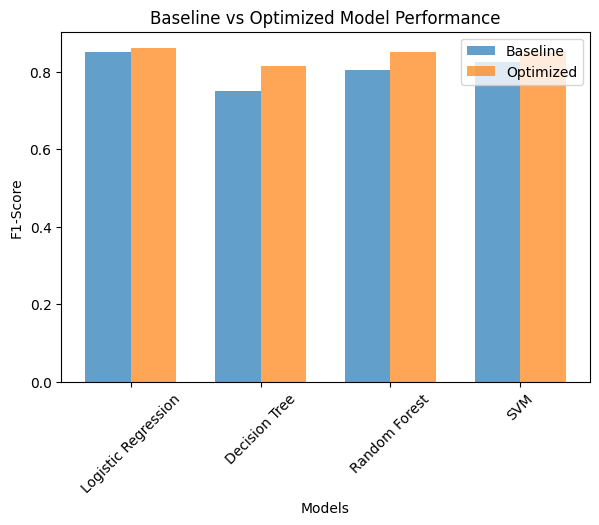

In [24]:


comparison_data = []
for model_name in base_models.keys():
    comparison_data.append({
        'Model': model_name,
        'Baseline_F1': baseline_results[model_name]['mean_f1'],
        'Optimized_F1': optimized_results[model_name]['best_score'],
        'Improvement': optimized_results[model_name]['best_score'] - baseline_results[model_name]['mean_f1'],
        'Tuning_Time': optimized_results[model_name]['tuning_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualization
plt.figure(figsize=(15, 10))

# 1. Baseline vs Optimized Performance
plt.subplot(2, 2, 1)
x = np.arange(len(base_models))
width = 0.35

baseline_scores = [baseline_results[name]['mean_f1'] for name in base_models.keys()]
optimized_scores = [optimized_results[name]['best_score'] for name in base_models.keys()]

plt.bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.7)
plt.bar(x + width/2, optimized_scores, width, label='Optimized', alpha=0.7)

plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Baseline vs Optimized Model Performance')
plt.xticks(x, list(base_models.keys()), rotation=45)
plt.legend()


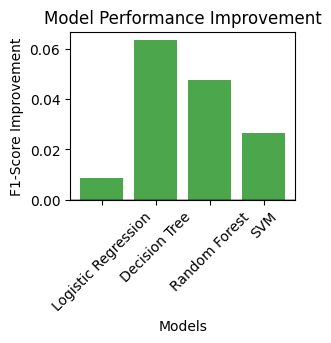

In [25]:

# 2. Performance Improvement
plt.subplot(2, 2, 2)
improvements = [optimized_results[name]['best_score'] - baseline_results[name]['mean_f1'] 
                for name in base_models.keys()]
colors = ['green' if imp > 0 else 'red' for imp in improvements]

plt.bar(list(base_models.keys()), improvements, color=colors, alpha=0.7)
plt.xlabel('Models')
plt.ylabel('F1-Score Improvement')
plt.title('Model Performance Improvement')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)


([0, 1, 2, 3],
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'Decision Tree'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'SVM')])

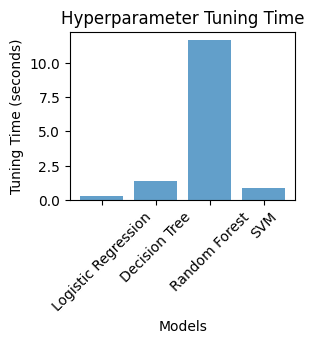

In [26]:
# 3. Tuning Time
plt.subplot(2, 2, 3)
tuning_times = [optimized_results[name]['tuning_time'] for name in base_models.keys()]
plt.bar(list(base_models.keys()), tuning_times, alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Tuning Time (seconds)')
plt.title('Hyperparameter Tuning Time')
plt.xticks(rotation=45)

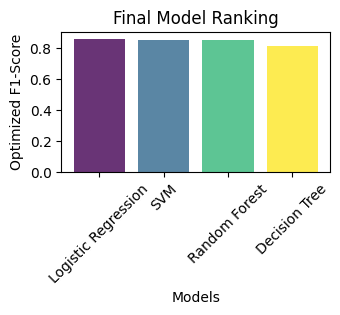

In [27]:
# 4. Final Performance Ranking
plt.subplot(2, 2, 4)
final_scores = [(name, optimized_results[name]['best_score']) for name in base_models.keys()]
final_scores.sort(key=lambda x: x[1], reverse=True)

names, scores = zip(*final_scores)
colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
plt.bar(names, scores, color=colors, alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Optimized F1-Score')
plt.title('Final Model Ranking')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [28]:
# Select best overall model
best_model_name = max(optimized_results.keys(), key=lambda k: optimized_results[k]['best_score'])
final_best_model = best_models[best_model_name]
best_score = optimized_results[best_model_name]['best_score']

print(f"\n🏆 FINAL BEST MODEL: {best_model_name}")
print(f"   Optimized F1-Score: {best_score:.4f}")
print(f"   Best Parameters: {optimized_results[best_model_name]['best_params']}")

# Save the final optimized model
joblib.dump(final_best_model, '../models/final_model.pkl')

# Save hyperparameter tuning results
tuning_results_df = pd.DataFrame({
    'Model': list(optimized_results.keys()),
    'Best_F1_Score': [optimized_results[name]['best_score'] for name in optimized_results.keys()],
    'Best_Parameters': [str(optimized_results[name]['best_params']) for name in optimized_results.keys()],
    'Tuning_Time_Seconds': [optimized_results[name]['tuning_time'] for name in optimized_results.keys()]
})

tuning_results_df.to_csv('../results/hyperparameter_tuning_results.csv', index=False)



🏆 FINAL BEST MODEL: Logistic Regression
   Optimized F1-Score: 0.8596
   Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


In [29]:
# Test final model performance
print(f"\n📊 FINAL MODEL EVALUATION")
print("="*30)
final_cv_scores = cross_val_score(final_best_model, X, y, cv=5, scoring='f1')
print(f"Final Model CV F1-Score: {final_cv_scores.mean():.4f} (+/- {final_cv_scores.std() * 2:.4f})")

print(f"\n✔️ Hyperparameter tuning completed")
print(f"✔️ Best model saved as: final_model.pkl")
print(f"✔️ Tuning results saved to hyperparameter_tuning_results.csv")


📊 FINAL MODEL EVALUATION
Final Model CV F1-Score: 0.8596 (+/- 0.0851)

✔️ Hyperparameter tuning completed
✔️ Best model saved as: final_model.pkl
✔️ Tuning results saved to hyperparameter_tuning_results.csv
